## Import Data and Impute Missing Values

In [112]:
import pandas as pd
import numpy as np

# Import the dataset
df = pd.read_csv("./data/heart_2022_with_nans.csv", sep=",")
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [113]:
#Impute the missing values and check for any remaining missing values
obj_cols = df.select_dtypes(include=["object"]).columns
num_cols = df.select_dtypes(include=[np.number]).columns

for col in obj_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
    
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
    
df[df.isna().any(axis=1)]

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos


## Helper Functions

In [114]:
# Calculate and return a dictionary with the percent size of each value in a dataframe column
def valueSplit(df, column = None):
    if column != None:
        countDict = df[column].value_counts().to_dict()
    else:
        countDict = df.value_counts().to_dict()
        
    totalCount = 0
    for values in countDict.values():
        totalCount += values
    for key in countDict.keys():
        countDict[key] = countDict[key] / totalCount * 100
    
    return countDict

In [115]:
# Returns the proportion of Yes values in the sample
def getValueProportion(y):
    values = valueSplit(y)
    prob = values['Yes'] / values['No']
    return prob

In [116]:
# Replace the categorical fields of the data with a numerical representation 
def euclidDistanceDataCleaning(dataframe):
    EDDF = dataframe.drop(columns=["State", "BMI", "TetanusLast10Tdap", 'HadDiabetes', 'RaceEthnicityCategory'])
    origList = ['Yes', 'No', 
                'Female', 'Male', 
                'Excellent', 'Very good', 'Good', 'Fair', 'Poor',
                'Within past year (anytime less than 12 months ago)', 'Within past 2 years (1 year but less than 2 years ago)', 'Within past 5 years (2 years but less than 5 years ago)', '5 or more years ago',
                'None of them', '1 to 5', '6 or more, but not all', 'All',
                'Current smoker - now smokes every day', 'Current smoker - now smokes some days', 'Former smoker', 'Never smoked',
                'Never used e-cigarettes in my entire life', 'Not at all (right now)', 'Use them some days', 'Use them every day',
                'Age 18 to 24', 'Age 25 to 29', 'Age 30 to 34', 'Age 35 to 39', 'Age 40 to 44', 'Age 45 to 49', 'Age 50 to 54', 'Age 55 to 59', 'Age 60 to 64', 'Age 65 to 69', 'Age 70 to 74', 'Age 75 to 79', 'Age 80 or older',
                'Tested positive using home test without a health professional']
    newList = [1, 0, 
               1, 0, 
               4, 3, 2, 1, 0,
               0, 1, 2, 3,
               0, 1, 2, 3,
               3, 2, 1, 0,
               0, 1, 2, 3,
               21, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 85,
               1]
    return EDDF.replace(origList, newList)

In [117]:
# Undersample the data so that the target variable has roughly a 50/50 split
import random
import time
random.seed(time.time())

def undersample(X, Y):
    x = X.copy()
    y = Y.copy()
    prob = getValueProportion(y)
    
    indexList = []
    for index, row in x.iterrows():
        
        if random.random() > prob and y[index] == 'No':
            indexList.append(index)
    
    x.drop(index=indexList, inplace = True)
    y.drop(index=indexList, inplace = True)
    return x, y


In [118]:
# Helper function for displaying results
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def displayResults(y_actual, y_prediction):
    print(f"====== Accuracy and Error Rate ==============")
    acc_score = metrics.accuracy_score(y_actual, y_prediction)
    print(f"Accuracy score: {acc_score * 100}%.")
    print(f"Error rate: {(1 - acc_score) * 100}%.")

    print(f"========== Classification Report ============")
    print(metrics.classification_report(y_actual, y_prediction))

    print(f"============ Confusion Matrix ==============")
    _ = ConfusionMatrixDisplay.from_predictions(y_actual, y_prediction)
    plt.title("Confusion Matrix")
    plt.show()


In [119]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Helper function for splitting and scaling the the data
def splitAndScale(x, y, scalerType = "Standard", undersampleData = True, 
                  test_size = 0.3, random_state = 42, shuffle = True):
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    if scalerType == "Standard":
        scalar = StandardScaler()
    elif scalerType == "MinMax":
        scalar = MinMaxScaler()
    else:
        raise ValueError('An invalid scalar was used.')
                  
    scaler = StandardScaler()
    x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x.columns)
    x_test = pd.DataFrame(scaler.transform(x_test), columns=x.columns)
    y_train.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)

    # Undersample the data
    if undersampleData:
        x_train, y_train = undersample(x_train, y_train)
                  
    return x_train, x_test, y_train, y_test
    
        

## Split Data

In [120]:
X = df.drop(columns = ["HadHeartAttack"])
y = df["HadHeartAttack"]
X = euclidDistanceDataCleaning(X)
X.shape

(445132, 34)

## Support Vector Machines

In [121]:
# Perform a standard scaler transformation on the data for the SVM Model
SVMX_train, SVMX_test, SVMy_train, SVMy_test = splitAndScale(X, y, scalerType = "Standard")

====== Accuracy and Error Rate ==============
Accuracy score: 83.27916729069942%.
Error rate: 16.72083270930058%.
========== Classification Report ============
              precision    recall  f1-score   support

          No       0.98      0.84      0.90    125936
         Yes       0.22      0.75      0.34      7604

    accuracy                           0.83    133540
   macro avg       0.60      0.79      0.62    133540
weighted avg       0.94      0.83      0.87    133540

============ Confusion Matrix ==============


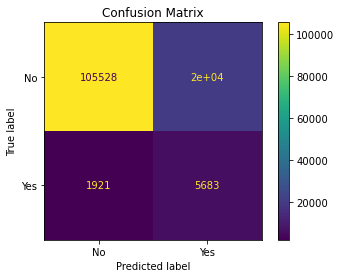

In [122]:
from sklearn.linear_model import SGDClassifier

SGDSVM_Model = SGDClassifier()
SGDSVM_Model.fit(SVMX_train, SVMy_train)
SGDSVMPrediction = SGDSVM_Model.predict(SVMX_test)
displayResults(SVMy_test, SGDSVMPrediction)

## One Class SVM

In [123]:
OneClassSVMX_train, OneClassSVMX_test, OneClassSVMy_train, OneClassSVMy_test = splitAndScale(X, y, 
                                                                                             undersampleData = False, 
                                                                                             scalerType = "Standard")

====== Accuracy and Error Rate ==============
Accuracy score: 71.3561479706455%.
Error rate: 28.6438520293545%.
========== Classification Report ============
              precision    recall  f1-score   support

          No       0.94      0.75      0.83    125936
         Yes       0.03      0.14      0.05      7604

    accuracy                           0.71    133540
   macro avg       0.48      0.44      0.44    133540
weighted avg       0.88      0.71      0.79    133540

============ Confusion Matrix ==============


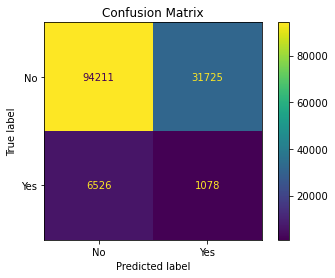

In [124]:
from sklearn.linear_model import SGDOneClassSVM

OneClassModel = SGDOneClassSVM(nu = getValueProportion(OneClassSVMy_train), random_state=42)
OneClassModel.fit(OneClassSVMX_train)
OneClassSGDSVMPrediction = OneClassModel.predict(OneClassSVMX_test)

OneClassSGDSVMPredictionTransformed = np.where(OneClassSGDSVMPrediction == -1, "Yes", "No")
displayResults(OneClassSVMy_test, OneClassSGDSVMPredictionTransformed)

## K-Nearest Neighbor

In [125]:
# Scale the data for the KNN Model
KNNX_train, KNNX_test, KNNy_train, KNNy_test = splitAndScale(X, y, scalerType = "MinMax")

In [126]:
from sklearn import neighbors

# Create and train the model and predict the result
KNNPredictionDict = {}
for n in [3, 5, 10]:
    knn_model = neighbors.KNeighborsClassifier(n_neighbors = n)
    knn_model.fit(KNNX_train, KNNy_train)
    KNNPredictionDict[n] = knn_model.predict(KNNX_test)

Results for 3 nearest neighbors
====== Accuracy and Error Rate ==============
Accuracy score: 77.02785682192601%.
Error rate: 22.97214317807399%.
========== Classification Report ============
              precision    recall  f1-score   support

          No       0.98      0.77      0.86    125936
         Yes       0.16      0.74      0.27      7604

    accuracy                           0.77    133540
   macro avg       0.57      0.76      0.57    133540
weighted avg       0.93      0.77      0.83    133540

============ Confusion Matrix ==============


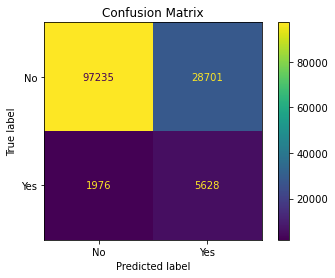

Results for 5 nearest neighbors
====== Accuracy and Error Rate ==============
Accuracy score: 78.72397783435675%.
Error rate: 21.276022165643248%.
========== Classification Report ============
              precision    recall  f1-score   support

          No       0.98      0.79      0.88    125936
         Yes       0.18      0.75      0.29      7604

    accuracy                           0.79    133540
   macro avg       0.58      0.77      0.58    133540
weighted avg       0.94      0.79      0.84    133540

============ Confusion Matrix ==============


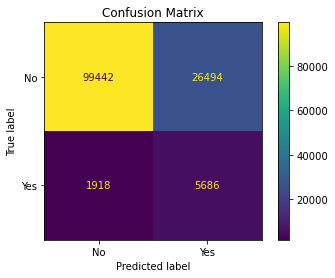

Results for 10 nearest neighbors
====== Accuracy and Error Rate ==============
Accuracy score: 83.37127452448705%.
Error rate: 16.62872547551295%.
========== Classification Report ============
              precision    recall  f1-score   support

          No       0.98      0.84      0.91    125936
         Yes       0.21      0.71      0.33      7604

    accuracy                           0.83    133540
   macro avg       0.60      0.78      0.62    133540
weighted avg       0.94      0.83      0.87    133540

============ Confusion Matrix ==============


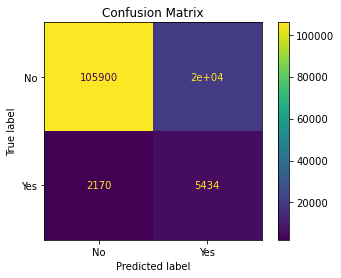

In [127]:
# Evaluate and display results
for n in KNNPredictionDict.keys():
    print("Results for {} nearest neighbors".format(n))
    displayResults(KNNy_test, KNNPredictionDict[n])